In [1]:
!pip install lightgbm;
!pip install optuna;
!pip install xgboost
!pip install catboost;

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import json
import gzip
import math
import numpy as np
import random
import statistics
import scipy.stats
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
from tqdm import tqdm
import sys
import warnings
import re

In [3]:
warnings.filterwarnings("ignore")
sns.set_style("white")
sns.despine()
plt.rcParams['font.family'] = 'monospace';

<Figure size 640x480 with 0 Axes>

In [4]:
event_df = pd.read_csv('train_logs.csv.zip')
event_df

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1
...,...,...,...,...,...,...,...,...,...,...,...
8405893,fff05981,3615,2063944,2064440,496,Nonproduction,Leftclick,Leftclick,NoChange,1031,240
8405894,fff05981,3616,2064497,2064497,0,Nonproduction,Shift,Shift,NoChange,1031,240
8405895,fff05981,3617,2064657,2064765,108,Replace,q,q,q => q,1031,240
8405896,fff05981,3618,2069186,2069259,73,Nonproduction,Leftclick,Leftclick,NoChange,1028,240


In [5]:
score_df = pd.read_csv('train_scores.csv')
score_df = score_df.set_index('id')
score_df

,score
id,
001519c8,3.5
0022f953,3.5
0042269b,6.0
0059420b,2.0
0075873a,4.0
...,...
ffb8c745,3.5
ffbef7e5,4.0
ffccd6fd,1.5


# Exploratory Data Analysis

I chose this data due to my personal interest in the use of typing patterns as indicators of certain behaviors, and this was a great way to understand the structure / nature of most typing data sets & train models on them. 

## First, let's look at the distribution of scores

We are trying to predict essay scores, so let's examine scores of essays

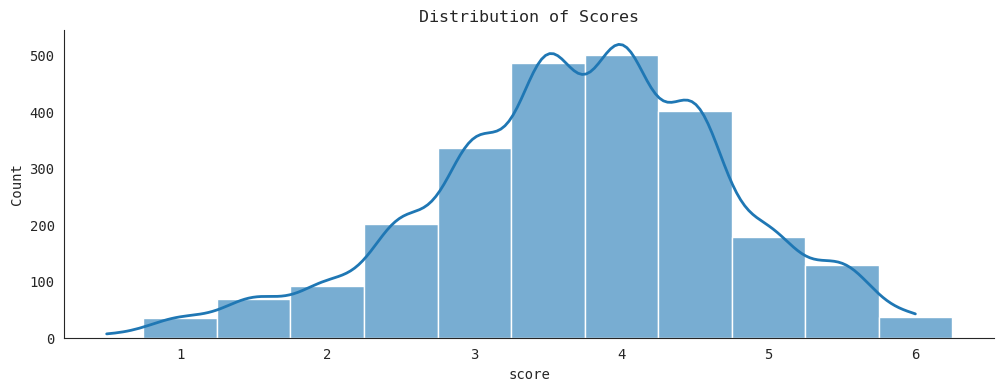

In [6]:
x1 = score_df["score"]
# Plot
# kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2}, bins=[0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6])

fig, ax = plt.subplots(figsize=(12,4), dpi= 100)
sns.despine()
ax = sns.histplot(x1, kde=True, line_kws={'linewidth':2},alpha=0.6, bins=[0.75,1.25,1.75,2.25,2.75,3.25,3.75,4.25,4.75,5.25,5.75,6.25])
ax.set_title('Distribution of Scores');

## Let's create some more basic features:
- `num_events` the number of events 
- `num_deletions` number of deletions
- `num_words` final word count of essay

In [7]:
## Functions for basic features:
def num_events(essay_id, df_dict):
    ft_df = df_dict[essay_id]
    return len(ft_df)

def num_deletions(essay_id, df_dict):
    counts =  df_dict[essay_id]['activity'].value_counts()
    if 'Remove/Cut' in counts.index:
        return counts['Remove/Cut']
    else:
        return 0

def num_words(essay_id, df_dict):
    count = df_dict[essay_id]['word_count'].iloc[-1]
    return count

In [8]:
## Create a dict of essay id to pandas dataframe - easy to get a specific dataframe's essay for feature extraction
essay_events = dict(tuple(event_df.groupby('id')))

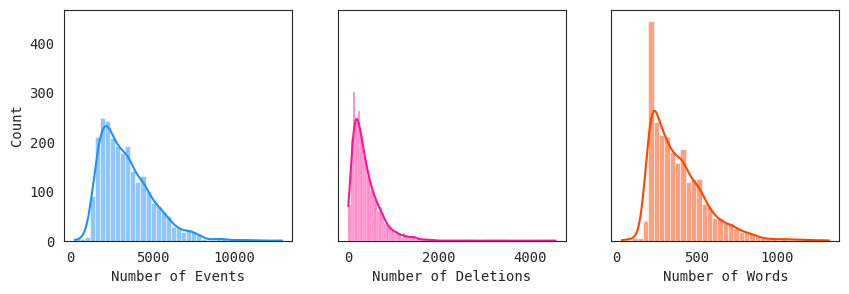

In [9]:
x1 = [num_events(index, essay_events) for index, row in score_df.iterrows()]
x2 = [num_deletions(index, essay_events) for index, row in score_df.iterrows()]
x3 = [num_words(index, essay_events) for index, row in score_df.iterrows()]

# plot
fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharey=True, dpi=100)
sns.histplot(x1 , color="dodgerblue", kde=True, ax=axes[0]).set_xlabel('Number of Events')
sns.histplot(x2 , color="deeppink", kde=True, ax=axes[1]).set_xlabel('Number of Deletions');
sns.histplot(x3 , color="orangered", kde=True, ax=axes[2]).set_xlabel('Number of Words');

## These distributions are clearly log-scaled, so let's make features that take the log of both of them

New Features:

- `log_num_events`
- `log_num_deletions`
- `log_num_words`

In [10]:
def log_num_events(essay_id, df_dict):
    return math.log2(num_events(essay_id, df_dict))

def log_num_deletions(essay_id, df_dict):
    return math.log2(num_deletions(essay_id, df_dict) + 1) # offset for log

def log_num_words(essay_id, df_dict):
    return math.log2(num_words(essay_id, df_dict))

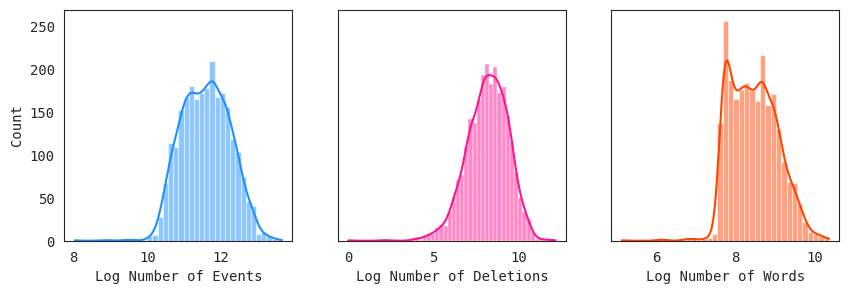

In [11]:
x1 = [log_num_events(index, essay_events) for index, row in score_df.iterrows()]
x2 = [log_num_deletions(index, essay_events) for index, row in score_df.iterrows()]
x3 = [log_num_words(index, essay_events) for index, row in score_df.iterrows()]

# plot
fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharey=True, dpi=100)
sns.histplot(x1 , color="dodgerblue", kde=True, ax=axes[0]).set_xlabel('Log Number of Events')
sns.histplot(x2 , color="deeppink", kde=True, ax=axes[1]).set_xlabel('Log Number of Deletions');
sns.histplot(x3 , color="orangered", kde=True, ax=axes[2]).set_xlabel('Log Number of Words');

# Prediction

## Naive Approach (Linear Regression)

The dataset has keystrokes from users, but the keys are anonymized as 'q' so the goal is to use the timestamps / ordering of events to train some model to predict the score of each essay. There are about 2500 users' essays in the dataset and nearly 8.5 million events, so I'll definitely have to drastically reduce dimensionality when I do regular classification. For now, though, we can see if we can fit a regression between # of events and the score for each essay.

In [12]:
from sklearn import linear_model

In [13]:
def MSE(predictions, actual):
    return sum((predictions[i] - actual[i])**2 for i in range(len(predictions))) / len(predictions)

In [14]:
## Train / Valid / Test Split:
seeds = [2004]

splits = [np.split(
    score_df.sample(frac=1, random_state = seed), [int(0.5 * len(score_df))]) for seed in seeds]

train_score_dfs = [split[0] for split in splits]
test_score_dfs = [split[1] for split in splits]

In [15]:
## All features separate: log and not log

X_trains_num_events = [[[num_events(essay_id, essay_events)] 
                         for essay_id, row in train_score_df.iterrows()] for train_score_df in train_score_dfs]
X_trains_log_num_events = [[[log_num_events(essay_id, essay_events)] 
                         for essay_id, row in train_score_df.iterrows()] for train_score_df in train_score_dfs]
X_trains_num_deletions = [[[num_deletions(essay_id, essay_events)] 
                         for essay_id, row in train_score_df.iterrows()] for train_score_df in train_score_dfs]
X_trains_log_num_deletions = [[[log_num_deletions(essay_id, essay_events)] 
                         for essay_id, row in train_score_df.iterrows()] for train_score_df in train_score_dfs]
X_trains_num_words = [[[num_words(essay_id, essay_events)] 
                         for essay_id, row in train_score_df.iterrows()] for train_score_df in train_score_dfs]
X_trains_log_num_words = [[[log_num_words(essay_id, essay_events)] 
                         for essay_id, row in train_score_df.iterrows()] for train_score_df in train_score_dfs]

y_trains = [[row['score'] for essay_id, row in train_score_df.iterrows()] for train_score_df in train_score_dfs]


X_tests_num_events = [[[num_events(essay_id, essay_events)] 
                         for essay_id, row in test_score_df.iterrows()] for test_score_df in test_score_dfs]
X_tests_log_num_events = [[[log_num_events(essay_id, essay_events)] 
                         for essay_id, row in test_score_df.iterrows()] for test_score_df in test_score_dfs]
X_tests_num_deletions = [[[num_deletions(essay_id, essay_events)] 
                         for essay_id, row in test_score_df.iterrows()] for test_score_df in test_score_dfs]
X_tests_log_num_deletions = [[[log_num_deletions(essay_id, essay_events)] 
                         for essay_id, row in test_score_df.iterrows()] for test_score_df in test_score_dfs]
X_tests_num_words = [[[num_words(essay_id, essay_events)] 
                         for essay_id, row in test_score_df.iterrows()] for test_score_df in test_score_dfs]
X_tests_log_num_words = [[[log_num_words(essay_id, essay_events)] 
                         for essay_id, row in test_score_df.iterrows()] for test_score_df in test_score_dfs]


y_tests = [[row['score'] for essay_id, row in test_score_df.iterrows()] for test_score_df in test_score_dfs]

In [16]:
regs_num_events = [linear_model.LinearRegression().fit(X_train, y_train) for (X_train, y_train) in zip(X_trains_num_events, y_trains)]

regs_log_num_events = [linear_model.LinearRegression().fit(X_train, y_train) for (X_train, y_train) in zip(X_trains_log_num_events, y_trains)]

regs_num_deletions = [linear_model.LinearRegression().fit(X_train, y_train) for (X_train, y_train) in zip(X_trains_num_deletions, y_trains)]

regs_log_num_deletions = [linear_model.LinearRegression().fit(X_train, y_train) for (X_train, y_train) in zip(X_trains_log_num_deletions, y_trains)]

regs_num_words = [linear_model.LinearRegression().fit(X_train, y_train) for (X_train, y_train) in zip(X_trains_num_words, y_trains)]

regs_log_num_words = [linear_model.LinearRegression().fit(X_train, y_train) for (X_train, y_train) in zip(X_trains_log_num_words, y_trains)]

In [17]:
y_preds_num_events = [reg.predict(X_test) for (reg, X_test) in zip(regs_num_events, X_tests_num_events)]
MSE_num_events = [MSE(y_pred, y_test) for y_pred, y_test in zip(y_preds_num_events, y_tests)]
print(f"MSES for num events: {MSE_num_events}") 

y_preds_log_num_events = [reg.predict(X_test) for (reg, X_test) in zip(regs_log_num_events, X_tests_log_num_events)]
MSE_log_num_events = [MSE(y_pred, y_test) for y_pred, y_test in zip(y_preds_log_num_events, y_tests)]
print(f"MSES for log num events: {MSE_log_num_events}") 

y_preds_num_deletions = [reg.predict(X_test) for (reg, X_test) in zip(regs_num_deletions, X_tests_num_deletions)]
MSE_num_deletions = [MSE(y_pred, y_test) for y_pred, y_test in zip(y_preds_num_deletions, y_tests)]
print(f"MSES for num deletions: {MSE_num_deletions}") 

y_preds_log_num_deletions = [reg.predict(X_test) for (reg, X_test) in zip(regs_log_num_deletions, X_tests_log_num_deletions)]
MSE_log_num_deletions = [MSE(y_pred, y_test) for y_pred, y_test in zip(y_preds_log_num_deletions, y_tests)]
print(f"MSES for log num deletions: {MSE_log_num_deletions}") 

y_preds_num_words = [reg.predict(X_test) for (reg, X_test) in zip(regs_num_words, X_tests_num_words)]
MSE_num_words = [MSE(y_pred, y_test) for y_pred, y_test in zip(y_preds_num_words, y_tests)]
print(f"MSES for num words: {MSE_num_words}") 

y_preds_log_num_words = [reg.predict(X_test) for (reg, X_test) in zip(regs_log_num_words, X_tests_log_num_words)]
MSE_log_num_words = [MSE(y_pred, y_test) for y_pred, y_test in zip(y_preds_log_num_words, y_tests)]
print(f"MSES for log num words: {MSE_log_num_words}") 

MSES for num events: [0.6803616180630022]
MSES for log num events: [0.6203263985569867]
MSES for num deletions: [0.9623295991847461]
MSES for log num deletions: [0.8905918720329442]
MSES for num words: [0.6030279358014377]
MSES for log num words: [0.5301670106313389]


In [18]:
## All features combined
X_trains_combined = [[[log_num_events(essay_id, essay_events), log_num_words(essay_id, essay_events)] 
                         for essay_id, row in train_score_df.iterrows()] for train_score_df in train_score_dfs]

X_tests_combined = [[[log_num_events(essay_id, essay_events), log_num_words(essay_id, essay_events)] 
                         for essay_id, row in test_score_df.iterrows()] for test_score_df in test_score_dfs]

regs_combined = [linear_model.LinearRegression().fit(X_train, y_train) for (X_train, y_train) in zip(X_trains_combined, y_trains)]

In [19]:
y_preds_combined = [reg.predict(X_test) for (reg, X_test) in zip(regs_combined, X_tests_combined)]
MSE_combined = [MSE(y_pred, y_test) for y_pred, y_test in zip(y_preds_combined, y_tests)]
print(f"MSES for log features combined: {MSE_combined}") 

MSES for log features combined: [0.5228547055186222]


## Enough is Enough with the linear regressions! 
We need to get organized when we add more features - which means it's time for CV!

In [20]:
# First thing is to get organized - need to have a way to add any features to a dataframe
# Desired feature is an array of (string, function) representing the name of feature and the function to calculate that feature for an id
def calculate_features(df_dict, desired_features, df):
    feature_df = df.copy()
    for (feature_name, feature_funct) in tqdm(desired_features):
        feature_list = [feature_funct(essay_id, df_dict) for essay_id, row in df.iterrows()]
        feature_df[feature_name] = feature_list
    return feature_df

In [21]:
from sklearn.model_selection import KFold

In [22]:
## Now, let's organize our splits with K-Fold Cross Validation
cross_validator = KFold(n_splits = 5, shuffle=True, random_state = 4424)

## Cross validation function to run any model on our folds & give all of the MSES
def cross_validate(model, df, cross_validator):
    X = df.drop('score', axis=1)
    y = df['score']

    mses = {}
    for fold, (train_index, valid_index) in enumerate(cross_validator.split(X, y)):
        X_train = X.iloc[train_index]
        X_valid = X.iloc[valid_index]
        y_train = y.iloc[train_index]
        y_valid = y.iloc[valid_index]

        model.fit(X_train, y_train)

        y_pred = model.predict(X_valid)

        mses[fold] = MSE(y_pred, y_valid)
        #print(mses[fold])

    return mses

## Time to engineer some new features!

These are feature recommendations from the paper *{ENTER}ing the Time Series {SPACE}: Uncovering the Writing Process through Keystroke Analyses* (Allen et al.). 

Using big words is probably indicative of high vocabulary. Creating a feature that weighs big words a certain way can lead to a stronger model.
- `avg_word_length`, `max_word_length`, `std_word_length`, `skew_word_length`, `kurtosis_word_length`
- `words_longer_4`, `words_longer_5`, `words_longer_6`, `words_longer_7`, `words_longer_8`, `words_longer_9`
Experienced writers can probably type fast. People pause while writing, but each pause while writing is probably no more than a second, so let's calculate typing speed & keep all pauses out of influencing this average.
- `avg_typing_speed`, `std_typing_speed`, `skew_typing_speed`, `kurtosis_typing_speed`
A good writer probably also takes certain amount of pauses between writing, so let's calculate the following:
- `pauses_0.5_second`, `pauses_1_second`, `pauses_1.5_second`, `pauses_2_second`, `pauses_2.5_second`, `pauses_3_second`
- `comma_count`, `period_count`, `question_mark_count`, `apostrophe_count`, `quote_count`, `exclamation_count`

In [23]:
def avg_word_length(essay_id, df_dict):
    essay_df = df_dict[essay_id]
    return np.mean([len(word) for word in word_list(essay_df)])

def max_word_length(essay_id, df_dict):
    essay_df = df_dict[essay_id]
    return max([len(word) for word in word_list(essay_df)])

def std_word_length(essay_id, df_dict):
    essay_df = df_dict[essay_id]
    return np.std([len(word) for word in word_list(essay_df)])

def skew_word_length(essay_id, df_dict):
    essay_df = df_dict[essay_id]
    return scipy.stats.skew([len(word) for word in word_list(essay_df)])

def kurtosis_word_length(essay_id, df_dict):
    essay_df = df_dict[essay_id]
    return scipy.stats.kurtosis([len(word) for word in word_list(essay_df)])


def words_longer_4(essay_id, df_dict):
    essay_df = df_dict[essay_id]
    return sum([len(word) > 4 for word in word_list(essay_df)])

def words_longer_5(essay_id, df_dict):
    essay_df = df_dict[essay_id]
    return sum([len(word) > 5 for word in word_list(essay_df)])

def words_longer_6(essay_id, df_dict):
    essay_df = df_dict[essay_id]
    return sum([len(word) > 6 for word in word_list(essay_df)])

def words_longer_7(essay_id, df_dict):
    essay_df = df_dict[essay_id]
    return sum([len(word) > 7 for word in word_list(essay_df)])

def words_longer_8(essay_id, df_dict):
    essay_df = df_dict[essay_id]
    return sum([len(word) > 8 for word in word_list(essay_df)])

def words_longer_9(essay_id, df_dict):
    essay_df = df_dict[essay_id]
    return sum([len(word) > 9 for word in word_list(essay_df)])


def word_list(essay_df):
    inputs_df = essay_df[essay_df['activity'] == 'Input']
    rough_essay = "".join(list(inputs_df['text_change']))
    return re.findall(r'q+', rough_essay)

In [24]:
def avg_typing_speed(essay_id, df_dict):
    essay_df = df_dict[essay_id]
    return np.mean(typing_gaps(essay_df))
    
def std_typing_speed(essay_id, df_dict):
    essay_df = df_dict[essay_id]
    return np.std(typing_gaps(essay_df))

def skew_typing_speed(essay_id, df_dict):
    essay_df = df_dict[essay_id]
    return scipy.stats.skew(typing_gaps(essay_df))

def kurtosis_typing_speed(essay_id, df_dict):
    essay_df = df_dict[essay_id]
    return scipy.stats.kurtosis(typing_gaps(essay_df))

def typing_gaps(essay_df):
    down_times = list(essay_df['down_time'])
    typing_gaps = [down_times[i] - down_times[i-1] for i in range(1,len(down_times))]
    typing_gaps_cleaned = [typing_gap for typing_gap in typing_gaps if typing_gap < 1000]
    return typing_gaps_cleaned

In [25]:
def pause_0_5_second(essay_id, df_dict):
    essay_df = df_dict[essay_id]
    return pauses(essay_df, 500)

def pause_1_second(essay_id, df_dict):
    essay_df = df_dict[essay_id]
    return pauses(essay_df, 1000)

def pause_1_5_second(essay_id, df_dict):
    essay_df = df_dict[essay_id]
    return pauses(essay_df, 1500)

def pause_2_second(essay_id, df_dict):
    essay_df = df_dict[essay_id]
    return pauses(essay_df, 2000)

def pause_2_5_second(essay_id, df_dict):
    essay_df = df_dict[essay_id]
    return pauses(essay_df, 2500)

def pause_3_second(essay_id, df_dict):
    essay_df = df_dict[essay_id]
    return pauses(essay_df, 3000)

def pauses(essay_df, threshold):
    down_times = list(essay_df['down_time'])
    typing_gaps = [down_times[i] - down_times[i-1] for i in range(1,len(down_times))]
    return sum(typing_gap > threshold for typing_gap in typing_gaps)

In [26]:
def comma_count(essay_id, df_dict):
    essay_df = df_dict[essay_id]
    return essay_df['up_event'].value_counts()[","] if "," in essay_df['up_event'].value_counts() else 0

def period_count(essay_id, df_dict):
    essay_df = df_dict[essay_id]
    return essay_df['up_event'].value_counts()["."] if "." in essay_df['up_event'].value_counts() else 0

def quote_count(essay_id, df_dict):
    essay_df = df_dict[essay_id]
    return essay_df['up_event'].value_counts()['"'] if '"' in essay_df['up_event'].value_counts() else 0

def apostrophe_count(essay_id, df_dict):
    essay_df = df_dict[essay_id]
    return essay_df['up_event'].value_counts()["'"] if "'" in essay_df['up_event'].value_counts() else 0

def question_count(essay_id, df_dict):
    essay_df = df_dict[essay_id]
    return essay_df['up_event'].value_counts()["?"] if "?" in essay_df['up_event'].value_counts() else 0

def exclamation_count(essay_id, df_dict):
    essay_df = df_dict[essay_id]
    return essay_df['up_event'].value_counts()["!"] if "!" in essay_df['up_event'].value_counts() else 0

In [27]:
desired_features = [('num_deletions', num_deletions), ('num_events', num_events), 
                    ('num_words', num_words), ('avg_word_length', avg_word_length ), ('max_word_length', max_word_length), 
                    ('std_word_length', std_word_length), ('skew_word_length', skew_word_length), 
                    ('kurtosis_word_length', kurtosis_word_length), ('words_longer_4', words_longer_4), 
                    ('words_longer_5', words_longer_5), ('words_longer_6', words_longer_6), ('words_longer_7', words_longer_7),
                    ('words_longer_8', words_longer_8), ('words_longer_9', words_longer_9),
                    ('avg_typing_speed', avg_typing_speed), ('skew_typing_speed', skew_typing_speed),
                    ('std_typing_speed', std_typing_speed), ('kurtosis_typing_speed', kurtosis_typing_speed),
                    ('pause_0_5_second', pause_0_5_second), ('pause_1_second', pause_1_second), ('pause_1_5_second', pause_1_5_second), 
                    ('pause_2_second', pause_2_second), ('pause_2_5_second', pause_2_5_second), ('pause_3_second', pause_3_second),
                    ('comma_count', comma_count), ('period_count', period_count), ('quote_count', quote_count), 
                    ('apostrophe_count', apostrophe_count), ('question_count', question_count), ('exclamation_count', exclamation_count) 
                   ]
ft_df = calculate_features(essay_events, desired_features, score_df)

100%|██████████| 30/30 [00:58<00:00,  1.94s/it]


30it [00:18,  1.66it/s]


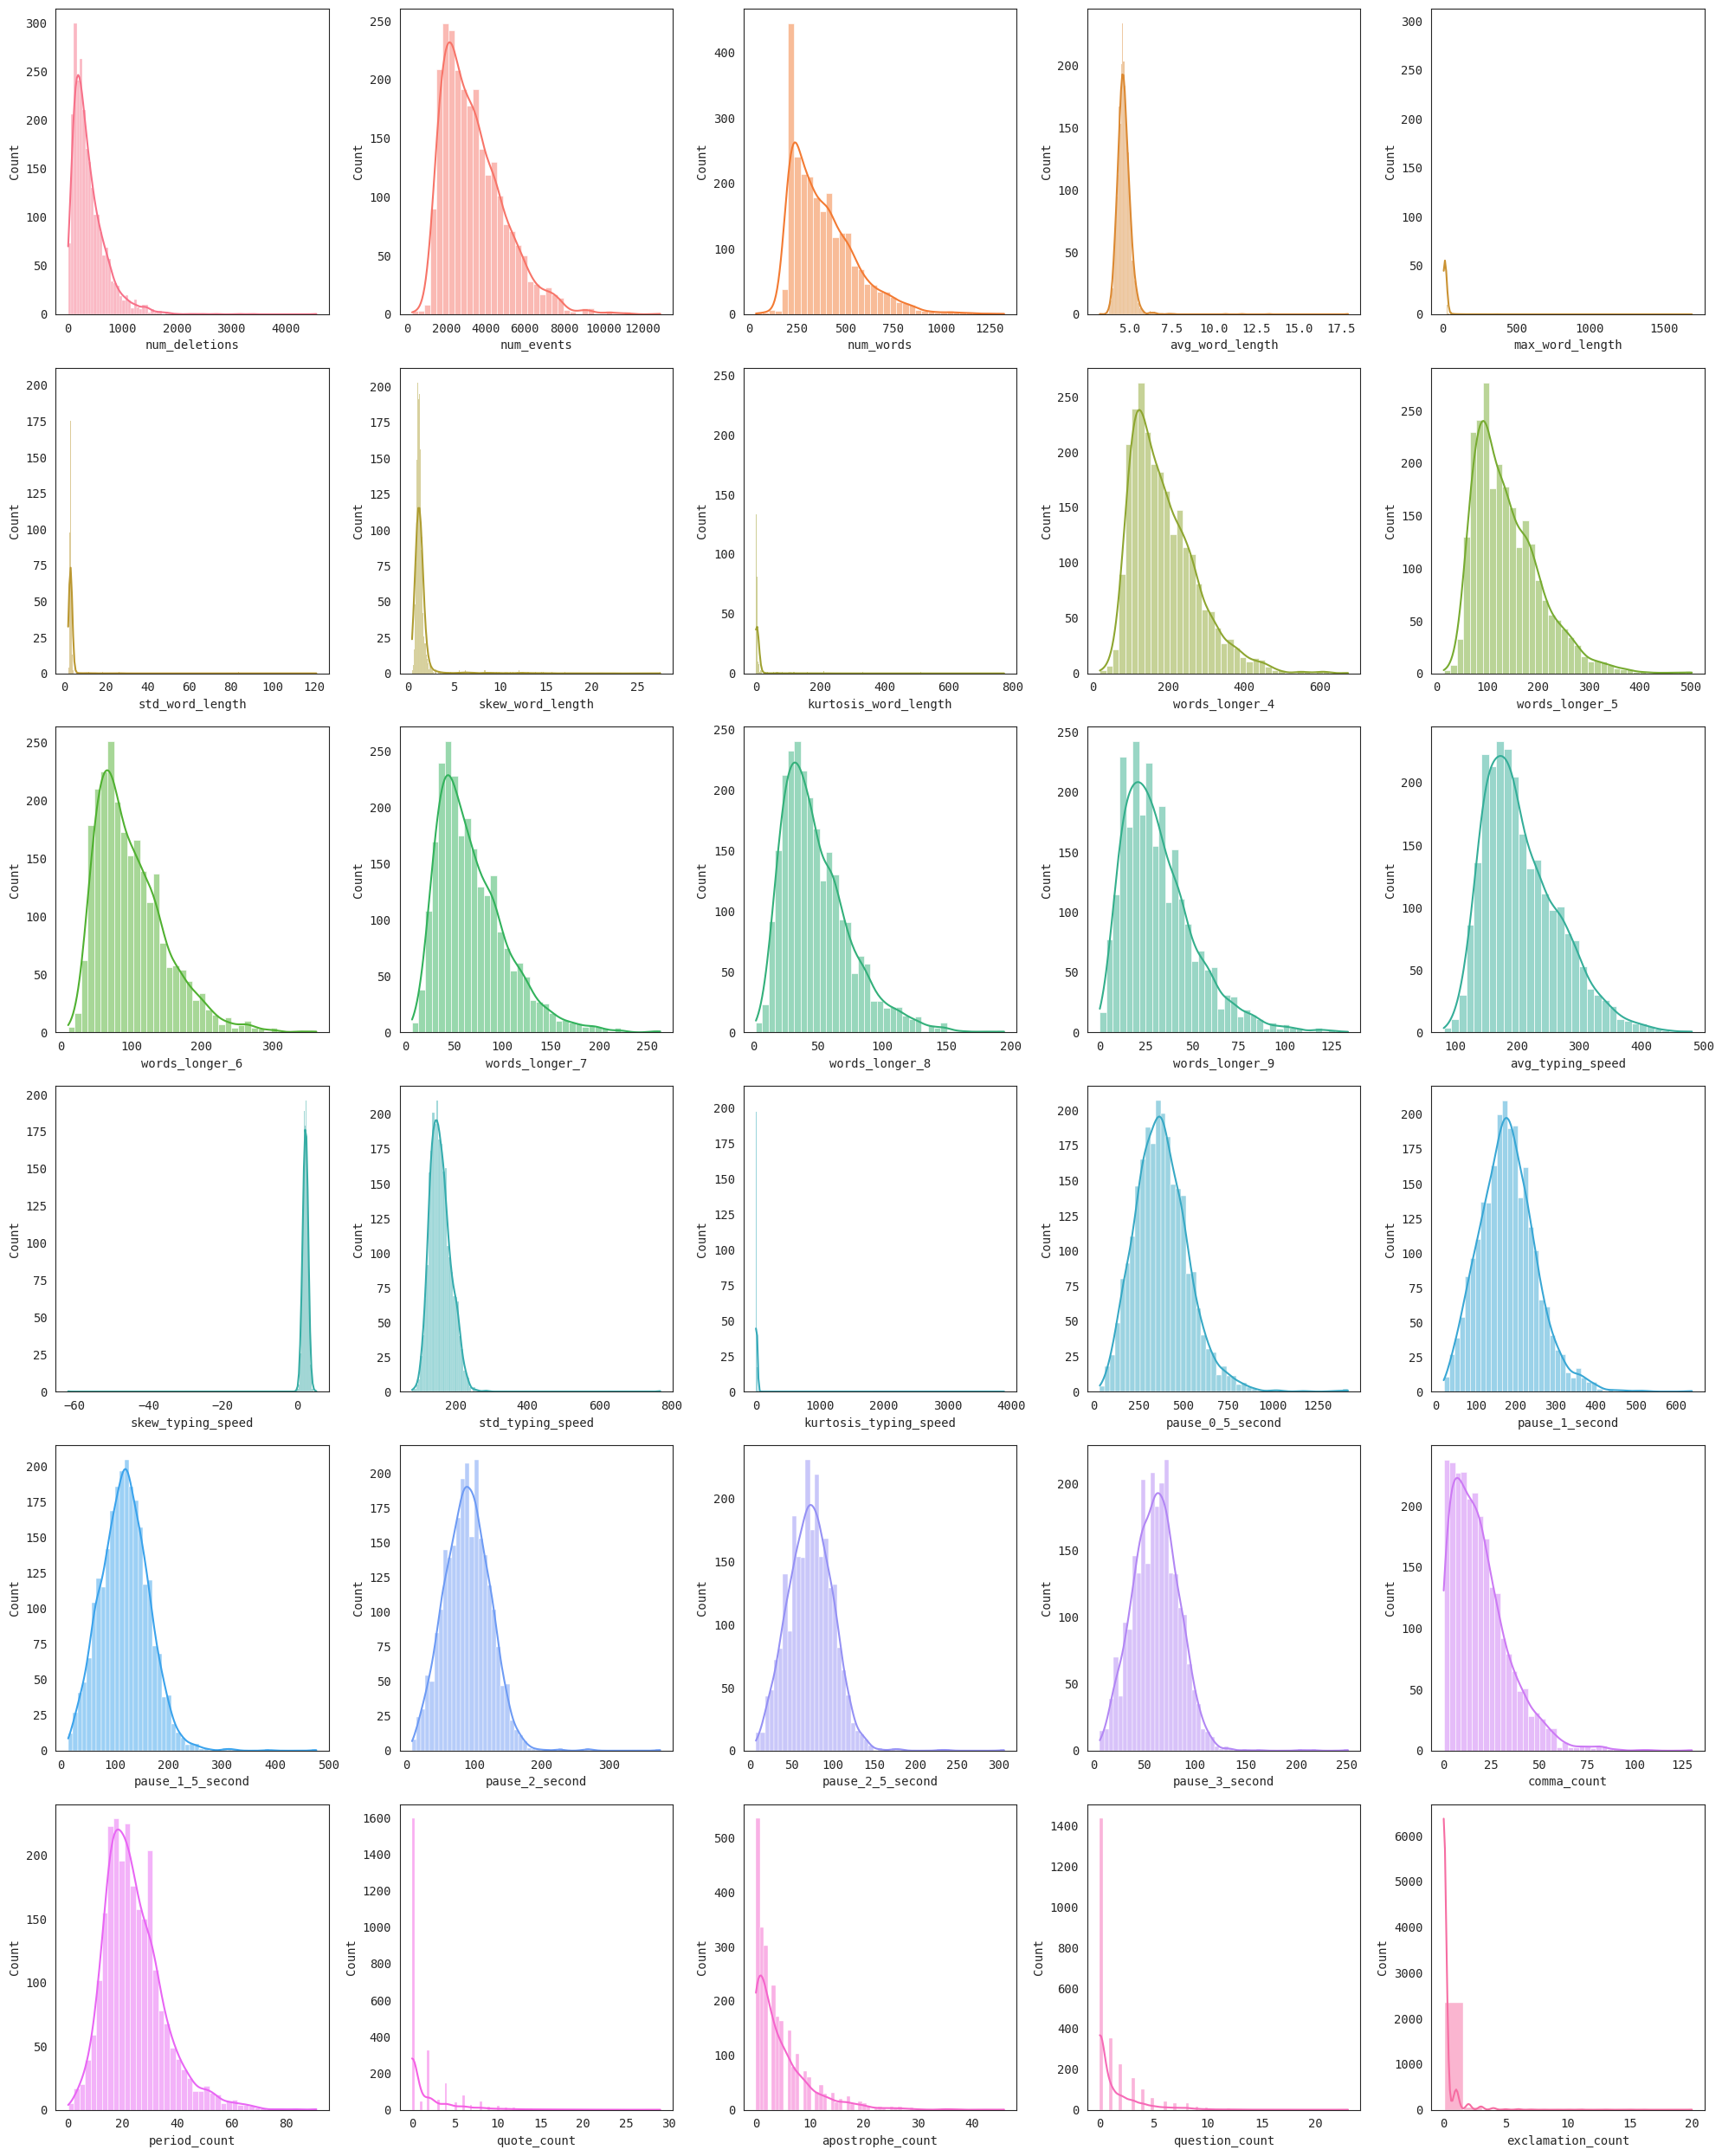

In [28]:
fig, axes = plt.subplots(6, 5, figsize=(20, 25), sharey=False, dpi=100)

axes = axes.flatten()

plot_df = ft_df.drop('score', axis=1)

palette = sns.color_palette("husl", len(plot_df.columns))

for idx, column in tqdm(enumerate(plot_df.columns)):
    sns.histplot(plot_df[column], color=palette[idx], kde=True, ax=axes[idx])
    axes[idx].set_xlabel(f'{column}')

for j in range(len(plot_df.columns), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [29]:
correlation_matrix = ft_df.corr()
plt.figure(figsize=(24, 24))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

KeyboardInterrupt: 

## Linear Regression with the new features

First, we should take the log of all features and put it in a new dataframe 

In [ ]:
log_ft_df = score_df.copy()
    
for col in ft_df.select_dtypes(include=[np.number]).columns:
    shifted_col = ft_df[col] - ft_df[col].min() + 1e-6
    log_ft_df[f'log_{col}'] = np.log(shifted_col)
log_ft_df = log_ft_df.drop('log_score', axis = 1)

In [ ]:
log_ft_df

In [ ]:
cross_validator = KFold(n_splits = 5, shuffle=True, random_state = 1)

model = linear_model.LinearRegression()
cross_validator = KFold(n_splits = 5, shuffle=True, random_state = 1)
print(cross_validate(model, log_ft_df, cross_validator))
cross_validator = KFold(n_splits = 2, shuffle=True, random_state = 10)
print(cross_validate(model, log_ft_df, cross_validator))
cross_validator = KFold(n_splits = 10, shuffle=True, random_state = 100)
print(cross_validate(model, log_ft_df, cross_validator))

I wonder what that outlier is! That's so weird. Either way, linear regression doesn't seem like it will work too well for our purposes.

## LGBM

In [ ]:
import lightgbm as lgbm
import optuna

### Hyperparameter tuning with Optuna

In [ ]:
'''
def objective(trial):
    # Define hyperparameter search space
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 20, 920, step=100),
    "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log=True), 
    "num_leaves": trial.suggest_int("num_leaves", 31, 128),  # Increase num_leaves
    "max_depth": trial.suggest_int("max_depth", 5, 15),
    "min_child_samples": trial.suggest_int("min_child_samples", 20, 100),
    "subsample": trial.suggest_float("subsample", 0.6, 1.0),
    "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
    "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
    "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
    }


    model = lgbm.LGBMRegressor(
        **param,
        random_state = 2004,
        verbose = -1
    )

    
    
    mse = np.mean(list(cross_validate(model, ft_df, cross_validator).values()))
    return mse

# Optimize hyperparameters
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

# Print best hyperparameters
print("Best trial:")
print(f"  Value: {study.best_trial.value}")
print(f"  Params: {study.best_trial.params}")
''';

In [ ]:
best_params_lgbm = {'n_estimators': 720, 'learning_rate': 0.0080471332618126, 'num_leaves': 40, 'max_depth': 6, 'min_child_samples': 62, 'subsample': 0.8462527946243993, 'colsample_bytree': 0.6561150463138162, 'reg_alpha': 0.12577846195573286, 'reg_lambda': 0.00016250067900248392}

In [ ]:
cross_validator = KFold(n_splits = 5, shuffle=True, random_state = 1000)
model = lgbm.LGBMRegressor(**best_params_lgbm, verbose = -1)
print(cross_validate(model, ft_df, cross_validator))
lgbm.plot_importance(model, importance_type="gain", figsize=(10, 8))

## XGBoost

In [ ]:
import xgboost as xgb

### Hyperparameter tuning with Optuna

In [ ]:
'''
def objective(trial):
    
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000, step=50),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),  
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),  
    }


    # Create the XGBoost model
    model = xgb.XGBRegressor(
        **param,
        objective="reg:squarederror",
        random_state=2004,
        verbosity=0
    )

    # Perform cross-validation
    mse = np.mean(list(cross_validate(model, ft_df, cross_validator).values()))
    return mse

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

# Print the best hyperparameters
print("Best trial:")
print(f"  Value: {study.best_trial.value}")
print(f"  Params: {study.best_trial.params}")
''';

In [ ]:
best_params_xgb = {'n_estimators': 950, 'learning_rate': 0.0160810859484404, 'max_depth': 6, 'min_child_weight': 7, 'gamma': 1.7599531886059028, 'subsample': 0.5322693117431363, 'colsample_bytree': 0.6169892944938316, 'reg_alpha': 0.0021079008780301913, 'reg_lambda': 4.363388877225225}

In [ ]:
cross_validator = KFold(n_splits = 5, shuffle=True, random_state = 1000)
model = xgb.XGBRegressor(**best_params_xgb)
print(cross_validate(model, ft_df, cross_validator))
xgb.plot_importance(model, importance_type="gain")

## CATBoost

In [ ]:
import catboost

In [ ]:
'''
def objective(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000, step=50),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),  
    }

    model = catboost.CatBoostRegressor(
        **param,
        loss_function="RMSE",
        random_seed=2004,
        verbose=500,
    )

    mse = np.mean(list(cross_validate(model, ft_df, cross_validator).values()))
    return mse

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

# Print the best hyperparameters
print("Best trial:")
print(f"  Value: {study.best_trial.value}")
print(f"  Params: {study.best_trial.params}")
''';

In [ ]:
best_params_catboost = {'n_estimators': 1000, 'learning_rate': 0.011560409310640193, 'max_depth': 5, 'reg_lambda': 0.41327714852736136}

In [ ]:
cross_validator = KFold(n_splits = 5, shuffle=True, random_state = 1000)
model = catboost.CatBoostRegressor(**best_params_catboost, logging_level = 'Silent')
print(cross_validate(model, ft_df, cross_validator))

In [ ]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(ft_df.columns)[sorted_idx])
plt.title('Feature Importance')

## PyTorch Feed Forward Neural Network

In [36]:
import torch
from torch import nn
import torch.optim.lr_scheduler as sched

In [45]:
def learn_pt(X_train, X_valid, y_train, y_valid, params):
    # hyperparams
    batch_size = params["bs"]
    learning_rate = params["lr"]
    n_epochs = params["n_epochs"]
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    X_train = torch.tensor(X_train.values, dtype=torch.float32).to(device)
    y_train = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1).to(device)
    X_valid = torch.tensor(X_valid.values, dtype=torch.float32).to(device)
    y_valid = torch.tensor(y_valid.values, dtype=torch.float32).reshape(-1, 1).to(device)

    model = nn.Sequential(nn.Linear(30, 32), nn.LayerNorm(32), nn.ReLU(),
                     nn.Linear(32, 64), nn.LayerNorm(64), nn.ReLU(),
                     nn.Linear(64, 32), nn.LayerNorm(32), nn.ReLU(),
                     nn.Linear(32, 1),).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = sched.ReduceLROnPlateau(optimizer, factor=params["factor"], patience=params["patience"])

    train_loss_history=[]
    val_loss_history=[]
    loss_fn = nn.MSELoss()
    batch_start = torch.arange(0, len(X_train), batch_size)

    count=0
    for epoch in range(n_epochs):
        print("EPOCH ", epoch+1)
        
        ## TRAIN PHASE :
        model.train()
        losses = []
        for features, labels in zip(X_train, y_train):
            features, labels = features.to(device), labels.to(device)
            optimizer.zero_grad()
            preds = model(features)
            loss = loss_fn(preds, labels)
            losses.append(float(loss)) 
            loss.backward()
            optimizer.step()
        with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                optimizer.zero_grad()
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                losses.append(float(loss))
                loss.backward()
                optimizer.step()
                bar.set_postfix(mse=float(loss))

        avg_loss = np.mean(losses)
        train_loss_history.append(avg_loss)

        print(f"Train Loss : {avg_loss}")
        
        ## VALIDATION PHASE : 
        model.eval()
        losses = []
        for features, labels in zip(X_valid, y_valid):
            features, labels = features.to(device), labels.to(device)
            preds = model(features)
            loss  = loss_fn(preds, labels)
            losses.append(float(loss))

        avg_loss = np.mean(losses)
        val_loss_history.append(avg_loss)

        print(f"Valid Loss : {avg_loss}")
        
        scheduler.step(avg_loss)
        count+=1
    losses_history = {"train" : train_loss_history, "valid" : val_loss_history}
    
    return model, losses_history

In [58]:
split_idx = int(0.8*len(ft_df))
end_idx = len(ft_df)

shuffled_df = ft_df.sample(frac=1, random_state = 404)

X_train = shuffled_df.iloc[0:split_idx].drop('score', axis=1)
X_valid = shuffled_df.iloc[split_idx:end_idx].drop('score', axis=1)
y_train = shuffled_df.iloc[0:split_idx]['score']
y_valid = shuffled_df.iloc[split_idx:end_idx]['score']

params = {"bs": 10,"lr": 0.001, "n_epochs":15, "factor": 0.5, "patience": 2}

mod, losses = learn_pt(X_train, X_valid, y_train, y_valid, params)

EPOCH  1
Train Loss : 0.7983088380104035
Valid Loss : 0.47687738748531266
EPOCH  2
Train Loss : 0.5029170569239767
Valid Loss : 0.45659537140610074
EPOCH  3
Train Loss : 0.47853322743507515
Valid Loss : 0.4501627149743326
EPOCH  4
Train Loss : 0.46596634496380984
Valid Loss : 0.4493301169853756
EPOCH  5
Train Loss : 0.4581374355842563
Valid Loss : 0.44735702983782194
EPOCH  6
Train Loss : 0.4528822906704768
Valid Loss : 0.4445626128158603
EPOCH  7
Train Loss : 0.4457365198071748
Valid Loss : 0.43993870864559165
EPOCH  8
Train Loss : 0.4421666867392273
Valid Loss : 0.44298095375676544
EPOCH  9
Train Loss : 0.4369469754750786
Valid Loss : 0.4421096357046763
EPOCH  10
Train Loss : 0.43524874230755356
Valid Loss : 0.43518778013852855
EPOCH  11
Train Loss : 0.4307043938323806
Valid Loss : 0.4402122513829527
EPOCH  12
Train Loss : 0.4270393677187969
Valid Loss : 0.437392518881756
EPOCH  13
Train Loss : 0.42600421718666476
Valid Loss : 0.44035157271185915
EPOCH  14
Train Loss : 0.405595443018

# Since I'm doing NN, might as well do tensorflow too

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LayerNormalization, ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [51]:
def learn_tf(X_train, X_valid, y_train, y_valid, params):
    learning_rate = params['lr']
    batch_size = params['bs']
    n_epochs = params['n_epochs']
    
    model = keras.Sequential([
        Dense(32, input_dim=30), LayerNormalization(axis=-1, epsilon=1e-3), ReLU(),
        Dense(64), LayerNormalization(axis=-1, epsilon=1e-3), ReLU(),
        Dense(128), LayerNormalization(axis=-1, epsilon=1e-3), ReLU(),
        Dense(64), LayerNormalization(axis=-1, epsilon=1e-3), ReLU(),
        Dense(32), LayerNormalization(axis=-1, epsilon=1e-3), ReLU(),
        Dense(1)])

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=params['factor'], patience=params['patience'], verbose=1)
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_valid, y_valid),
        batch_size=batch_size,
        epochs=n_epochs,
        callbacks=[reduce_lr]
    )
    
    
    loss= model.evaluate(X_valid, y_valid)
    print(f"Validation Loss: {loss}")

    return model, history

In [56]:
shuffled_df = ft_df.sample(frac=1, random_state = 404)
X_train = shuffled_df.iloc[0:split_idx].drop('score', axis=1)
X_valid = shuffled_df.iloc[split_idx:end_idx].drop('score', axis=1)
y_train = shuffled_df.iloc[0:split_idx]['score']
y_valid = shuffled_df.iloc[split_idx:end_idx]['score']

params = {"bs": 10,"lr": 0.001, "n_epochs":25, "factor": 0.5, "patience": 2}

learn_tf(X_train, X_valid, y_train, y_valid, params)

Epoch 1/25
198/198 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 1.0657 - val_loss: 0.5883 - learning_rate: 0.0010
Epoch 2/25
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.6121 - val_loss: 0.4890 - learning_rate: 0.0010
Epoch 3/25
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.4643 - val_loss: 0.7280 - learning_rate: 0.0010
Epoch 4/25
195/198 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4937
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.4937 - val_loss: 0.5791 - learning_rate: 0.0010
Epoch 5/25
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.4664 - val_loss: 0.4991 - learning_rate: 5.0000e-04
Epoch 6/25
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.4316 - val_loss: 0.4633 - learning_rate: 5.0000e-04
Epoch 7/25
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.4392 - val_loss: 0.4814 - learning_rate: 5.0000e-04
Epoch 8/25
192/198 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4269
Epoch 8: ReduceLRO

(<Sequential name=sequential_8, built=True>,
 <keras.src.callbacks.history.History at 0x7f4f4c3e87d0>)